![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [192]:
import warnings
warnings.filterwarnings('ignore')

In [193]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [194]:
#print(data.dtypes)
#print(data.describe())

In [195]:
# Separación de variables predictoras (X) y variable de interés (y)
y = (data.Price > 14538).astype(int)#data['Price']
X = data.drop(['Price'], axis=1)

In [196]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [197]:
# Celda 1
# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001
# Impresión variable a usar (Hits)
j = 1
print(X.columns[j])

Mileage


In [198]:
# División de la variable Millas en num_ctp puntos (parámetro definido anteriormente) para obtener posibles puntos de corte
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())
splits = np.unique(splits)
splits

array([5.000000e+00, 1.576440e+04, 2.345860e+04, 2.993760e+04,
       3.570080e+04, 4.168000e+04, 4.824700e+04, 6.171600e+04,
       8.153420e+04, 1.067578e+05])

In [199]:
# División de las observaciones usando el punto de corte en la posición 5 de la lista de splits
k=5
filter_l = X.iloc[:, j] < splits[k]

# División de la variable de respuesta de acuerdo a si la observación cumple o no con la regla binaria
# y_l: la observación tiene un valor menor al punto de corte seleccionado
# y_r: la observación tiene un valor mayor o igual al punto de corte seleccionado
y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [200]:
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [201]:
# Gini index de las observaciones que tienen un valor menor al punto de corte seleccionado
gini_l = gini(y_l)
print(f'el gini de la izquierda es:{gini_l}')

# Gini index de las observaciones que tienen un valor mayor o igual al punto de corte seleccionado
gini_r = gini(y_r)
print(f'el gini de la derecha es:{gini_r}')

el gini de la izquierda es:0.20372460740541687
el gini de la derecha es:0.39922961360425346


In [202]:
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [203]:
# Ganancia de la variable 'Milage' en el punto de corte selecionado
gini_impurity(X.iloc[:, j], y, splits[k])

0.18565557739895322

In [204]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [205]:
# Obtención de la variable 'j', su punto de corte 'split' y su ganancia 'gain'
j, split, gain = best_split(X, y, 5)
j, split, gain


(1, 56176.00000000001, 0.2346214760886038)

In [206]:
y.shape[0], y_l.shape[0], y_r.shape[0]

(10495, 5247, 5248)

In [207]:
y.mean(), y_l.mean(), y_r.mean()

(0.5801810385898046, 0.8848866018677339, 0.27553353658536583)

In [208]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5)
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [209]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=2, num_pct=10)


In [210]:
 #Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted


In [211]:
y_pred=tree_predict(X_test, tree)

In [212]:
y_pred

array([0., 0., 1., ..., 1., 0., 0.])

In [213]:
# Calcular métricas de evaluación RMSE y MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score , f1_score
rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1Score = f1_score(y_test, y_pred)
# Imprimir resultados
print(f'RMSE del árbol de desición Manual: {rmse}')
print(f'MAE del árbol de desición Manual: {mae}')
print(f'El Accuracy para el modelo Arbol de desición Manuales: {accuracy}')
print(f'El f1-Score para el modelo Arbol de desición Manuales: {f1Score}')


RMSE del árbol de desición Manual: 0.14174364896073904
MAE del árbol de desición Manual: 0.14174364896073904
El Accuracy para el modelo Arbol de desición Manuales: 0.858256351039261
El f1-Score para el modelo Arbol de desición Manuales: 0.8832897551699549


### Analisis

Se realizó el modelo de arbol desición manual, calculando las diferentes metricas de rendimiento como el RMSE, MAE, Accurancy y F1Score, con parametros de  min_gain=0.001, max_depth=2. En donde se evidencia que el modelo tiene un rendimiento  del 90,06 % y una precisión de 88,68%. 

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [231]:
from sklearn.tree import DecisionTreeClassifier

# Definir función para crear y ajustar un árbol de decisión
def fit_tree(X_train, y_train, X_test):
    tree = DecisionTreeClassifier(max_depth=2,)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    return y_pred

# Crear 10 instancias de la función de árbol de decisión con diferentes conjuntos de entrenamiento
n_trees = 10
y_preds = []
for i in range(n_trees):
    sample_indices = np.random.choice(X_train.index, len(X_train))
    X_sample = X_train.loc[sample_indices]
    y_sample = y_train.loc[sample_indices]
    y_pred = fit_tree(X_sample, y_sample, X_test)
    y_preds.append(y_pred)

# Promediar las predicciones de cada árbol para obtener una predicción final
y_pred_bagM = np.mean(y_preds, axis=0)
y_pred_bagM =(np.rint(y_pred_bagM)).astype(int)
y_pred_bagM

array([0, 0, 1, ..., 1, 0, 0])

In [229]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score,f1_score
# Calcular MAE y MSE
maeBaggManual = mean_absolute_error(y_test, y_pred_bagM )
rmseBaggManual = mean_squared_error(y_test, y_pred_bagM )
accuracyBaggManual = accuracy_score(y_test, y_pred_bagM )
f1ScoreBaggManual = f1_score(y_test, y_pred_bagM )

# Imprimir resultados
print(f'El RMSE para el modelo Bagging manual es: {rmseBaggManual}')
print(f'El MAE para el modelo Bagging manual es: {maeBaggManual}')
print(f'El Accuracy para el modelo Bagging manual es: {accuracyBaggManual}')
print(f'El F1-Score para el modelo Bagging manual es: {f1ScoreBaggManual}')



El RMSE para el modelo Bagging manual es: 0.14289838337182448
El MAE para el modelo Bagging manual es: 0.14289838337182448
El Accuracy para el modelo Bagging manual es: 0.8571016166281755
El F1-Score para el modelo Bagging manual es: 0.8817769285884882


### Análisis del Desempeño

Se realizó el modelo de Baggin manual con 10 árboles , calculando las diferentes metricas de rendimiento como el RMSE, MAE, Accurancy y F1Score, con el parametros max_depth=2. Se obtuvo que el modelo tiene un rendimiento del 88,17 % y una precisión de 85.71%. 

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [238]:
# Celda 3
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Crear modelo de Bagging con 10 árboles de clasificación y max_features=log(n_features)
n_features = X_train.shape[1]
max_features = int(np.log(n_features))
print(f'El valor del max_features es: {max_features}')
bagging = BaggingClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=10,
    max_features=max_features,
    random_state=42
)

# Entrenar modelo con los datos de entrenamiento
bagging.fit(X_train, y_train)

# Evaluar modelo con los datos de prueba
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score
y_pred_bagg = bagging.predict(X_test)
maeBagg = mean_absolute_error(y_test, y_pred_bagg)
rmseBagg = mean_squared_error(y_test, y_pred_bagg)
accuracyBagg = accuracy_score(y_test, y_pred_bagg)
f1ScoreBagg = f1_score(y_test, y_pred_bagg )

# Imprimir resultado
print(f'El RMSE para el modelo Bagging es: {rmseBagg}')
print(f'El MAE para el modelo Bagging es: {maeBagg}')
print(f'El Accuracy para el modelo Bagging es: {accuracyBagg}')
print(f'El F1-Score para el modelo Bagging es: {f1ScoreBagg}')

El valor del max_features es: 2
El RMSE para el modelo Bagging es: 0.1642609699769053
El MAE para el modelo Bagging es: 0.1642609699769053
El Accuracy para el modelo Bagging es: 0.8357390300230947
El F1-Score para el modelo Bagging es: 0.8735274505445655


### Análisis del Desempeño

Se realizó el modelo de Baggin con libreria con 10 árboles , calculando las diferentes metricas de rendimiento como el RMSE, MAE, Accurancy y F1Score, con el parametros max_depth=2 y max_features= 2. Se obtuvo que el modelo tiene un rendimiento del 87,35 % y una precisión de 83.57%. Se observa que este modelo tiene menor desempeño que el modelo anterior de Bagging manual debido a que se usan menos variables predictoras.  

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación  y comenten sobre el desempeño del modelo.

In [241]:
# Celda 4
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Crear modelo de Random Forest 
rf = RandomForestClassifier()

# Entrenar modelo con los datos de entrenamiento
rf.fit(X_train, y_train)

# Evaluar modelo con los datos de prueba
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score
y_pred_rf = rf.predict(X_test)
maeRF= mean_absolute_error(y_test, y_pred_rf)
rmseRF= mean_squared_error(y_test, y_pred_rf)
accuracyRF = accuracy_score(y_test, y_pred_rf)
f1ScoreRF = f1_score(y_test, y_pred_rf )

# Imprimir resultado
print(f'El RMSE para el modelo Random Forest es: {rmseRF}')
print(f'El MAE para el modelo Random Forest es: {maeRF}')
print(f'El Accuracy para el modelo Random Forest es: {accuracyRF}')
print(f'El F1-Score para el modelo Random Forest es: {f1ScoreRF}')

El RMSE para el modelo Random Forest es: 0.15617782909930716
El MAE para el modelo Random Forest es: 0.15617782909930716
El Accuracy para el modelo Random Forest es: 0.8438221709006929
El F1-Score para el modelo Random Forest es: 0.8668471572729511


### Análisis del Desempeño

Se realizó el modelo de Ramdom Forest con libreria , calculando las diferentes metricas de rendimiento como el RMSE, MAE, Accurancy y F1Score, con el parametros por defecto. Se obtuvo que el modelo tiene un rendimiento del 86,68 % y una precisión de 84.38%.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [242]:
# Celda 5
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    rf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(rf, X, y, cv=5, scoring='accuracy').mean())

max_accuracy = max(accuracy_scores)
max_index = accuracy_scores.index(max_accuracy)
max_estimator = estimator_range[max_index]

print(f'El valor máximo de accuracy_scores es: {max_accuracy},con un n_estimators de: {max_estimator}')


El valor máximo de accuracy_scores es: 0.8414483087184375,con un n_estimators de: 20


Text(0, 0.5, 'Accuracy')

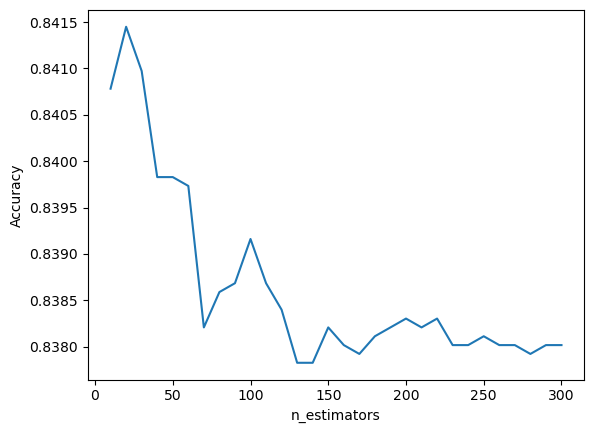

In [243]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
import matplotlib.pyplot as plt
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')


In [220]:
# Selección de variables predictoras
#print(X)
feature_cols = data.columns.drop('Price')
feature_cols

Index(['Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL',
       'M_CamryLE', 'M_CamrySE', 'M_CamryXLE'],
      dtype='object')

In [244]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(feature_cols)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    rf = RandomForestClassifier(n_estimators=20, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(rf, X, y, cv=5, scoring='accuracy').mean())

max_accuracy = max(accuracy_scores)
max_index = accuracy_scores.index(max_accuracy)
max_feature = feature_range[max_index]

print(f'El valor máximo de accuracy_scores es: {max_accuracy},con un max_feature de: {max_feature}')


El valor máximo de accuracy_scores es: 0.8500238208670796,con un max_feature de: 9


Text(0, 0.5, 'Accuracy')

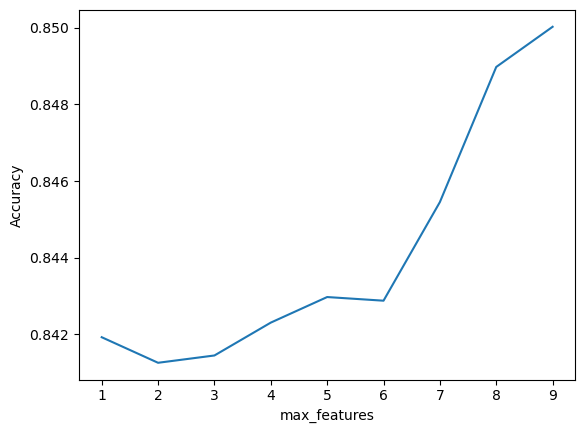

In [245]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

El valor máximo de accuracy_scores es: 0.8821343496903287, con un max_depth de: 6


Text(0, 0.5, 'Accuracy')

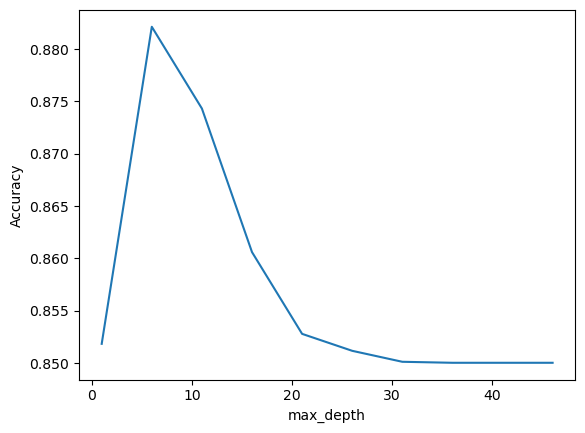

In [223]:
# Creación de lista de valores para iterar sobre diferentes valores de max_depth
depth_range = range(1,51,5)
# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_depth
accuracy_scores = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for depth in depth_range:
    rf = RandomForestClassifier(n_estimators=20, max_features=9, max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(rf, X, y, cv=5, scoring='accuracy').mean())

max_accuracy = max(accuracy_scores)
max_index = accuracy_scores.index(max_accuracy)
max_depth = depth_range[max_index]

print(f'El valor máximo de accuracy_scores es: {max_accuracy}, con un max_depth de: {max_depth}')

# Gráfica del desempeño del modelo vs la cantidad de max_depth
plt.plot(depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')


In [247]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Definición del modelo con los parámetros max_features, max_depth y n_estimators 
rfp = RandomForestClassifier(n_estimators=20, max_features=9, max_depth= 6)

# Entrenar modelo con los datos de entrenamiento
rfp.fit(X_train, y_train)

# Evaluar modelo con los datos de prueba
from sklearn.metrics import accuracy_score
y_pred_rfp = rfp.predict(X_test)
maeRFP= mean_absolute_error(y_test, y_pred_rfp)
rmseRFP= mean_squared_error(y_test, y_pred_rfp)
accuracyRFP = accuracy_score(y_test, y_pred_rfp)
f1ScoreRFP = f1_score(y_test, y_pred_rfp )
# Imprimir resultado
print(f'El RMSE para el modelo Random Forest es: {rmseRFP}')
print(f'El MAE para el modelo Random Forest es: {maeRFP}')
print(f'El Accuracy para el modelo Random Forest es: {accuracyRFP}')
print(f'El F1-Score para el modelo Random Forest es: {f1ScoreRFP}')


El RMSE para el modelo Random Forest es: 0.11143187066974596
El MAE para el modelo Random Forest es: 0.11143187066974596
El Accuracy para el modelo Random Forest es: 0.8885681293302541
El F1-Score para el modelo Random Forest es: 0.9071669071669073


### Análisis del Desempeño

Se realizó el modelo de Ramdom Forest con calibración de parametros, calculando las diferentes metricas de rendimiento como el RMSE, MAE, Accurancy y F1Score, con el parametros por defecto. 

- El accuracy máximo se obtuvo con 20 estimadores. Si se aumenta el valor de los estimadores el accuracy disminuye.
- El accuracy máximo se obtuvo con max_features=9, que seria incluyento todas las variabes independientes del DataSet. En la grafica se observa que a mayor número de variables el acuracy aumenta.
- El accuracy máximo se obtuvo con max_depth= 6, Si se aumenta el valor de profundidad del modelo el accuracy disminuye. 

Se obtuvo que el modelo tiene un rendimiento del 90,71 % y una precisión de 88,85%.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn y comenten sobre el desempeño del modelo.

In [249]:
# Celda 6
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Crear modelo XGBoost de clasificación
xgb = XGBClassifier(random_state=42)

# Entrenar modelo con los datos de entrenamiento
xgb.fit(X_train, y_train)

# Realizar predicciones sobre los datos de prueba
y_pred_xgb = xgb.predict(X_test)


In [251]:

# Calcular precisión del modelo en los datos de prueba
maeXGB= mean_absolute_error(y_test, y_pred_xgb)
rmseXGB= mean_squared_error(y_test, y_pred_xgb)
accuracyXGB = accuracy_score(y_test, y_pred_xgb)
f1ScoreXGB = f1_score(y_test, y_pred_xgb)


# Imprimir resultado
print(f'El RMSE para el modelo Random Forest es: {rmseXGB}')
print(f'El MAE para el modelo Random Forest es: {maeXGB}')
print(f'El Accuracy para el modelo XGBoost es: {accuracyXGB}')
print(f'El F1-Score para el modelo XGBoost es: {f1ScoreXGB}')


El RMSE para el modelo Random Forest es: 0.11431870669745958
El MAE para el modelo Random Forest es: 0.11431870669745958
El Accuracy para el modelo XGBoost es: 0.8856812933025404
El F1-Score para el modelo XGBoost es: 0.9047160731472569


### Análisis del Desempeño

Se realizó el modelo de XGBoost con libreria , calculando las diferentes metricas de rendimiento como el RMSE, MAE, Accurancy y F1Score, con el parametros por defecto. Se obtuvo que el modelo tiene un rendimiento del 90,47 % y una precisión de 88.56%.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [265]:
# Celda 7
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Definición del clasificador XGBoost
xgb_param = xgb.XGBClassifier()

# Definición de la grilla de valores para cada parámetro
params = {'learning_rate': [0.01, 0.1, 0.3],
          'gamma': [0, 0.1, 0.5],
          'colsample_bytree': [0.5, 0.7, 1.0]}

# Búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=xgb_param, param_grid=params, scoring='accuracy', cv=5)

# Ajuste del modelo con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Selección de los mejores parámetros y su desempeño
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluación del modelo con los datos de test
y_pred = grid_search.predict(X_test)
accuracyXGBP = accuracy_score(y_test, y_pred_XGBP)

# Impresión de resultados
print(f"Mejores parámetros es: {best_params}")
#print(f"Mejor desempeño en validación cruzada es: {best_score:.3f}")
#print(f'El Accuracy para el modelo XGBoost con paremetors calibrados es: {accuracyXGBP:.3f}')

Mejores parámetros es: {'colsample_bytree': 0.7, 'gamma': 0.5, 'learning_rate': 0.01}


In [263]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Crear modelo XGBoost de clasificación
xgb = XGBClassifier(colsample_bytree= 0.7, gamma= 0.5, learning_rate= 0.01)

# Entrenar modelo con los datos de entrenamiento
xgb.fit(X_train, y_train)

# Realizar predicciones sobre los datos de prueba
y_pred_XGBP = xgb.predict(X_test)


In [264]:
# Calcular precisión del modelo en los datos de prueba
maeXGBP= mean_absolute_error(y_test, y_pred_XGBP)
rmseXGBP= mean_squared_error(y_test, y_pred_XGBP)
accuracyXGBP = accuracy_score(y_test, y_pred_XGBP)
f1ScoreXGBP = f1_score(y_test, y_pred_XGBP)


# Imprimir resultado
print(f'El RMSE para el modelo XGBoost con paremetors calibrados es: {rmseXGBP}')
print(f'El MAE para el modelo XGBoost con paremetors calibrados es: {maeXGBP}')
print(f'El Accuracy para el modelo XGBoost con paremetors calibrados es: {accuracyXGBP}')
print(f'El F1-Score para el modelo XGBoost con paremetors calibrados es: {f1ScoreXGBP}')

El RMSE para el modelo XGBoost con paremetors calibrados es: 0.11316397228637413
El MAE para el modelo XGBoost con paremetors calibrados es: 0.11316397228637413
El Accuracy para el modelo XGBoost con paremetors calibrados es: 0.8868360277136259
El F1-Score para el modelo XGBoost con paremetors calibrados es: 0.9066666666666665


### Análisis del Desempeño

Se realizó el modelo de XGboost con calibración de parametros, calculando las diferentes metricas de rendimiento como el RMSE, MAE, Accurancy y F1Score, con el parametros por defecto. 

- colsample_bytree= 0.7
- gamma= 0.5
- learning_rate= 0.01

Se obtuvo que el modelo tiene un rendimiento del 90,66 % y una precisión de 88,68%.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

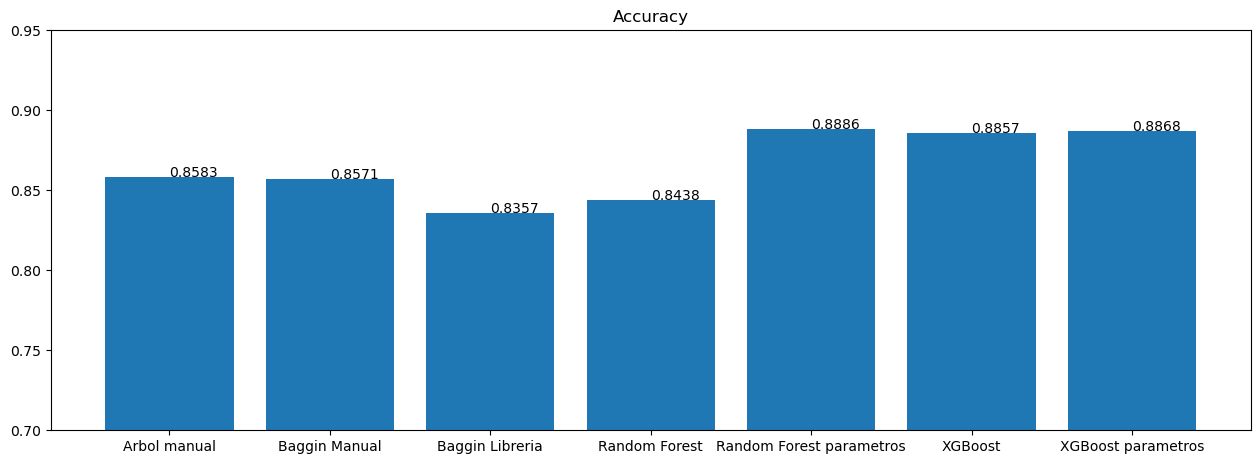

In [286]:
#Celda 8
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,4))
ax = fig.add_axes([0,0,1,1])

ax.set_title("Accuracy")
ejeX = ['Arbol manual','Baggin Manual','Baggin Libreria','Random Forest', 'Random Forest parametros','XGBoost','XGBoost parametros']
ejeY = [round(accuracy,4), round(accuracyBaggManual,4),round(accuracyBagg,4), round(accuracyRF,4), round(accuracyRFP,4), round(accuracyXGB,4), round(accuracyXGBP,4)]
ax.bar(ejeX,ejeY)
plt.ylim(0.7,0.95)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()
